The goal of this neural network is to determine the usefulness of an article. 

A prompt is given to the Ollama LLM to classify an article as 0 (not useful) or 1 (useful)

The neural network is then trained on a set of articles that the LLM has classified. 

After training, a new article can be inputed and given a score of 0 or 1 for it's usefulness with respect to the initial prompt.

In [3]:

import numpy as np
import os
import pickle
import copy
import ollama


import pandas as pd
import matplotlib.pyplot as plt

import requests
import xml.etree.ElementTree as ET
import ollama
from sklearn.model_selection import train_test_split



import time


Here's a breakdown of the libraries we're importing:

`numpy` handles numerical computations for the neural network, 
`ollama` interfaces with the language model for embeddings and summaries, 
and `requests with xml.etree.ElementTree` enables PubMed API interactions to fetch article data. 
`pandas` organizes article metadata, `matplotlib` visualizes training metrics, and `sklearn` ensures proper train-test splitting. 


Additionally, `pickle` enables efficient data caching to store processed article embeddings and labels, reducing redundant computations. `time` is used for tracking processing duration, aiding performance optimization.

These dependencies enable seamless data processing, model training, and result analysis, ensuring the project is robust and scalable.



In [4]:

#----------------
# LAYER DENSE
#----------------


class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = .01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        if self.weight_regularizer_l1 > 0:
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dl1
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        if self.bias_regularizer_l1 > 0:
            dl1 = np.ones_like(self.biases)
            dl1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dl1
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

    def get_parameters(self):
        return self.weights, self.biases

    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases

class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs, training):
        self.inputs = inputs
        if not training:
            self.output = inputs.copy()
        else:
            self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
            self.output = inputs * self.binary_mask
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        return self.dinputs  # Added return

class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs
        return self.output

#----------------
# ACTIVATION FUNCTIONS
#----------------


class Activation_ReLU:
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs

    def predictions(self, outputs):
        return outputs

class Activation_Sigmoid:

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

    def backward(self, dvalues):
        if self.output is None:
            raise ValueError("Sigmoid backward: self.output is None; forward pass may not have been called correctly")
        self.dinputs = dvalues * (1 - self.output) * self.output
        return self.dinputs

    def predictions(self, outputs):
        return (outputs > 0.5) * 1


#----------------
# OPTIMIZER
#----------------


class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1


#----------------
# LOSS FUNCTIONS
#----------------


class Loss:
    def regularization_loss(self):
        regularization_loss = 0
        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        return regularization_loss

    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        if not include_regularization:
            return data_loss
        return data_loss, self.regularization_loss()

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0



class Loss_BinaryCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        if len(y_true.shape) == 1:
            y_true = y_true[:, np.newaxis]
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_dvalues = np.clip(dvalues, 1e-7, 1-1e-7)
        if len(y_true.shape) == 1:
            y_true = y_true[:, np.newaxis]
        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs
        self.dinputs = self.dinputs / samples
        return self.dinputs


#----------------
# ACCURACY
#----------------


class Accuracy:
    def calculate(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)  # Fraction of correct predictions
        self.accumulated_sum += np.sum(comparisons)  # Total correct
        self.accumulated_count += len(comparisons)   # Total samples
        return accuracy  # No need to cap if computed correctly

    def calculate_accumulated(self):
        if self.accumulated_count == 0:
            return 0
        accuracy = self.accumulated_sum / self.accumulated_count
        return min(accuracy, 1.0)  # Cap here to catch any overflow

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Accuracy_Binary(Accuracy):
    def __init__(self):
        self.new_pass()

    def compare(self, predictions, y):
        # Ensure both predictions and y are 1D
        binary_predictions = (predictions > 0.5).flatten()  # Convert to 1D boolean
        if len(y.shape) == 2:
            y = y.flatten()  # Ensure y is 1D
        if len(binary_predictions) != len(y):
            raise ValueError(f"Shape mismatch: predictions {binary_predictions.shape}, y {y.shape}")
        return binary_predictions == y  # 1D boolean array

These classes define the core components of the neural network architecture. 
Layer_Dense implements fully connected layers with support for L1/L2 regularization to prevent overfitting, crucial for handling high-dimensional article embeddings. 

Layer_Dropout introduces randomization during training to enhance model generalization, critical for small datasets. 

Layer_Input serves as the entry point for data, ensuring compatibility with the network. Together, they form a flexible, custom-built neural network tailored for binary classification of article usefulness.

Activation functions introduce non-linearity and map outputs to desired ranges. 
Activation_ReLU accelerates training by applying a non-linear transformation to hidden layers, promoting sparse activations. 

Activation_Sigmoid is used in the output layer to produce probabilities between 0 and 1, ideal for binary classification of articles as useful or not useful. These functions ensure the model can learn complex patterns and deliver interpretable predictions.



The Optimizer_SGD class implements stochastic gradient descent with momentum and learning rate decay, optimizing the neural network’s weights to minimize prediction errors. Momentum accelerates convergence by incorporating past gradients, while decay adjusts the learning rate to stabilize training. This optimizer ensures efficient and effective training, enabling the model to learn from article embeddings and improve classification accuracy.




Loss_BinaryCrossEntropy computes the loss for binary classification, guiding the model to minimize errors in predicting article usefulness. It includes regularization to penalize overly complex models, enhancing generalization. Accuracy_Binary measures the proportion of correct predictions, providing a clear metric to evaluate model performance. These components are essential for training and assessing the model’s ability to classify articles accurately.



In [5]:
#----------------
# MODEL OBJECT
#----------------

class funny_guy:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def set(self, *, loss, optimizer, accuracy):
        if loss is not None:
            self.loss = loss
        if optimizer is not None:
            self.optimizer = optimizer
        if accuracy is not None:
            self.accuracy = accuracy

    def finalize(self):
        self.input_layer = Layer_Input()
        layer_count = len(self.layers)
        self.trainable_layers = []
        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.layers[i + 1]
            else:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)

    def forward(self, X, training):
        self.input_layer.forward(X, training)
        output = self.input_layer.output
        for layer in self.layers:
            output = layer.forward(output, training)
        return output

    def backward(self, output, y):
        dvalues = self.loss.backward(output, y)
        for layer in reversed(self.layers):
            dvalues = layer.backward(dvalues)
        return dvalues

    def train(self, X, y, *, epochs=1, batch_size=None, print_every=1, validation_data=None):
        # Initialize history dictionary
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        train_steps = 1
        if batch_size is not None:
            train_steps = len(X) // batch_size
            if train_steps * batch_size < len(X):
                train_steps += 1

        for epoch in range(1, epochs + 1):
            print(f'epoch: {epoch}')
            self.loss.new_pass()
            self.accuracy.new_pass()

            for step in range(train_steps):
                batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
                batch_y = y if batch_size is None else y[step * batch_size:(step + 1) * batch_size]

                output = self.forward(batch_X, training=True)
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)

                self.backward(output, batch_y)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, acc: {accuracy:.3f}, loss: {loss:.3f}, '
                          f'(data_loss: {data_loss}, reg_loss: {regularization_loss:.3f}), '
                          f'lr: {self.optimizer.current_learning_rate}')

            # Store training metrics
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            self.history['train_loss'].append(epoch_loss)
            self.history['train_acc'].append(epoch_accuracy)
            print(f'training, acc: {epoch_accuracy:.3f}, loss: {epoch_loss:.3f}, '
                  f'(data_loss: {epoch_data_loss}, reg_loss: {epoch_regularization_loss:.3f}), '
                  f'lr: {self.optimizer.current_learning_rate}')

            # Store validation metrics if provided
            if validation_data is not None:
                X_val, y_val = validation_data
                val_loss, val_acc = self.evaluate(X_val, y_val, batch_size=batch_size)
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)
            else:
                self.history['val_loss'].append(None)
                self.history['val_acc'].append(None)

        return self.history  # Return history for plotting

    def evaluate(self, X_val, y_val, *, batch_size=None):
        validation_steps = 1
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1
        self.loss.new_pass()
        self.accuracy.new_pass()

        for step in range(validation_steps):
            batch_X = X_val if batch_size is None else X_val[step * batch_size:(step + 1) * batch_size]
            batch_y = y_val if batch_size is None else y_val[step * batch_size:(step + 1) * batch_size]
            output = self.forward(batch_X, training=False)
            self.loss.calculate(output, batch_y)
            predictions = self.output_layer_activation.predictions(output)
            self.accuracy.calculate(predictions, batch_y)

        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()
        print(f'validation, acc: {validation_accuracy:.3f}, loss: {validation_loss:.3f}')
        print(f"Val predictions: {predictions.flatten()}")
        return validation_loss, validation_accuracy  # Return metrics for history

    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        output = []
        for step in range(prediction_steps):
            batch_X = X if batch_size is None else X[step * batch_size:(step + 1) * batch_size]
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)
        return np.vstack(output)



The funny_guy class orchestrates the neural network by managing layers, loss, optimizer, and accuracy. It supports forward and backward passes, training, evaluation, and prediction. 

The train method logs performance metrics and supports validation, enabling iterative improvements. 

This modular design allows easy experimentation with architectures and hyperparameters, making the model adaptable for classifying article usefulness.



In [4]:
#----------------
# Pubmed Scraping 
#----------------


def fetch_pubmed_ids(query, max_results=20):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    search_url = f"{base_url}esearch.fcgi?db=pubmed&term={query}&retmax={max_results}&retmode=xml"
    response = requests.get(search_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch IDs: {response.status_code}")
    root = ET.fromstring(response.content)
    return [id_elem.text for id_elem in root.findall(".//Id")]

def fetch_pubmed_details(pmids):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    fetch_url = f"{base_url}efetch.fcgi?db=pubmed&id={','.join(pmids)}&retmode=xml"
    response = requests.get(fetch_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch details: {response.status_code}")
    fetch_root = ET.fromstring(response.content)
    articles = {}
    fetched_pmids = set()
    for article in fetch_root.findall(".//PubmedArticle"):
        pmid = article.findtext(".//PMID")
        title = article.findtext(".//ArticleTitle") or "No title"
        abstract = article.findtext(".//AbstractText") or ""
        articles[pmid] = {'title': title, 'abstract': abstract}
        fetched_pmids.add(pmid)
    missing = set(pmids) - fetched_pmids
    if missing:
        print(f"Warning: Missing PMIDs in fetch: {missing}")
    return articles

def get_ollama_embedding(text, model='nomic-embed-text'):
    response = ollama.embeddings(model=model, prompt=text)
    return np.array(response['embedding'])

def get_ollama_summary(text, model='llama3'):
    prompt = f"Summarize the following article in 2-3 sentences:\n\n{text}"
    response = ollama.generate(model=model, prompt=prompt)
    return response['response']

def normalize_embeddings(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    return (X - X_mean) / (X_std + 1e-8)  # Avoid division by zero






Loading saved data from article_data.pkl
epoch: 1
step: 0, acc: 0.500, loss: 0.699, (data_loss: 0.6987388006625573, reg_loss: 0.000), lr: 0.005
step: 2, acc: 0.500, loss: 0.694, (data_loss: 0.6943909165786921, reg_loss: 0.000), lr: 0.00499001996007984
step: 3, acc: 0.750, loss: 0.691, (data_loss: 0.6913583640660993, reg_loss: 0.000), lr: 0.0049850448654037895
training, acc: 0.438, loss: 0.696, (data_loss: 0.6956638943860933, reg_loss: 0.000), lr: 0.0049850448654037895
validation, acc: 0.250, loss: 0.698
Val predictions: [0 0 0 1]
epoch: 2
step: 0, acc: 0.500, loss: 0.692, (data_loss: 0.6922669095794045, reg_loss: 0.000), lr: 0.0049800796812749
step: 2, acc: 0.750, loss: 0.687, (data_loss: 0.6874622072334874, reg_loss: 0.000), lr: 0.004970178926441352
step: 3, acc: 0.750, loss: 0.690, (data_loss: 0.690380427700798, reg_loss: 0.000), lr: 0.00496524329692155
training, acc: 0.500, loss: 0.692, (data_loss: 0.6915346271511962, reg_loss: 0.000), lr: 0.00496524329692155
validation, acc: 0.000,

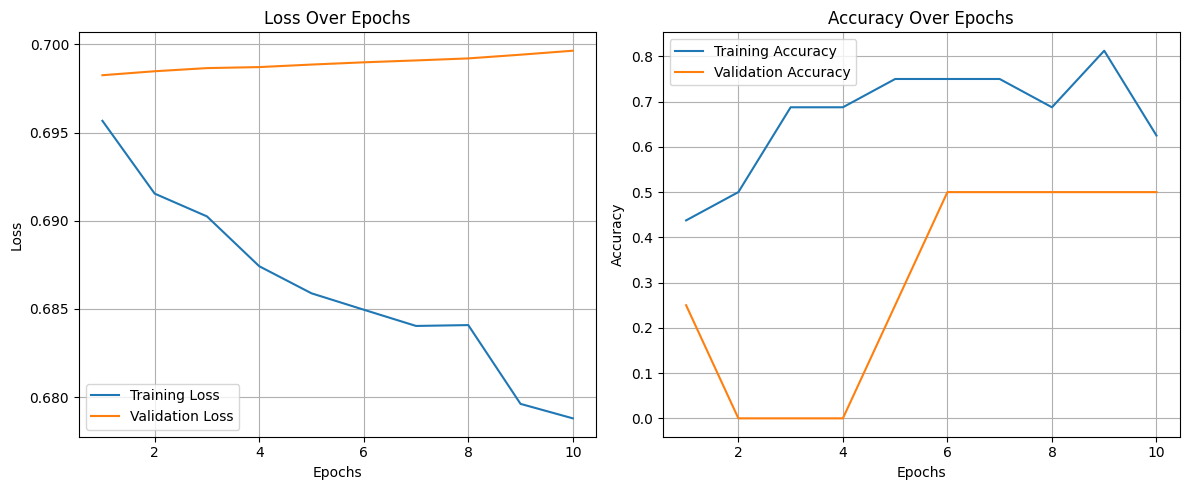

In [6]:
# Manually Label Scraped Articles 
# 1 Useful, 0 Not useful



def process_articles(pmids, articles_dict):
    X, y, texts, summaries = [], [], [], []
    valid_pmids = []
    
    # Step 1: Fetch and summarize articles
    for pmid in pmids:
        if pmid not in articles_dict:
            print(f"Warning: PMID {pmid} not found in articles_dict, skipping.")
            continue
        article = articles_dict[pmid]
        full_text = f"{article['title']} {article['abstract']}"
        summary = get_ollama_summary(full_text)
        embedding = get_ollama_embedding(summary)
        X.append(embedding)
        texts.append(full_text)
        summaries.append(summary)
        valid_pmids.append(pmid)
    
    X = np.array(X)
    
    # Step 2: Prompt user to label based on summaries
    print("Label the following articles based on their summaries (1 = useful, 0 = not useful):")
    y = []
    for i, pmid in enumerate(valid_pmids):
        while True:
            try:
                label = int(input(f"PMID {pmid}: {summaries[i][:250]}...\nLabel (1/0): "))
                if label in [0, 1]:
                    y.append(label)
                    break
                print("Please enter 0 or 1.")
            except ValueError:
                print("Invalid input, please enter 0 or 1.")
    
    # Step 3: Print full text and summary for reference
    print("\nProcessed articles:")
    for pmid, text, summary, label in zip(valid_pmids, texts, summaries, y):
        print(f"PMID {pmid}:")
        print(f"Full Text: {text[:250]}...")
        print(f"Summary: {summary}")
        print(f"Label: {label}\n")
    
    return X, np.array(y)

def create_article_data(query, max_results=20):
    all_pmids = fetch_pubmed_ids(query, max_results)
    train_pmids, test_pmids = train_test_split(all_pmids, test_size=0.2, random_state=42)
    train_articles = fetch_pubmed_details(train_pmids)
    test_articles = fetch_pubmed_details(test_pmids)
    X_train, y_train = process_articles(train_pmids, train_articles)
    X_test, y_test = process_articles(test_pmids, test_articles)
    
    # Normalize embeddings after creation
    X_train = normalize_embeddings(X_train)
    X_test = normalize_embeddings(X_test)
    
    assert not set(train_pmids) & set(test_pmids), "Overlap detected!"
    return X_train, y_train, X_test, y_test

# File to save/load data
DATA_FILE = "article_data.pkl"

def load_or_create_data(query, max_results):
    """Load saved data if it exists, otherwise create and save it."""
    if os.path.exists(DATA_FILE):
        print(f"Loading saved data from {DATA_FILE}")
        with open(DATA_FILE, 'rb') as f:
            data = pickle.load(f)
            return data['X_train'], data['y_train'], data['X_test'], data['y_test']
    else:
        print(f"Creating new data for query: {query}")
        X_train, y_train, X_test, y_test = create_article_data(query, max_results)
        data = {
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        }
        with open(DATA_FILE, 'wb') as f:
            pickle.dump(data, f)
        print(f"Saved data to {DATA_FILE}")
        return X_train, y_train, X_test, y_test

if __name__ == "__main__":
    query = "machine learning cancer"
    max_results = 20

    # Load or create data
    X_train, y_train, X_test, y_test = load_or_create_data(query, max_results)

    # Build and train model
    model = funny_guy()
    model.add(Layer_Dense(768, 64))
    model.add(Activation_ReLU())
    model.add(Layer_Dropout(.2))
    model.add(Layer_Dense(64, 1))
    model.add(Activation_Sigmoid())
    model.set(
        loss=Loss_BinaryCrossEntropy(),
        optimizer=Optimizer_SGD(learning_rate=0.005, decay=1e-3),
        accuracy=Accuracy_Binary()
    )
    model.finalize()

    history = model.train(X_train, y_train, epochs=10, batch_size=4, print_every=2, validation_data=(X_test, y_test))

    # Predict
    predictions = model.predict(X_test[:5])
    print("Predictions:", predictions.flatten())

    # Plotting
    epochs_range = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

With only 20 articles, the model exhibited high validation loss (e.g., ~0.7) and accuracy barely above 50%, akin to random guessing. The small dataset limited the model’s ability to learn meaningful patterns from high-dimensional embeddings. Manual labeling of articles was also time-consuming, motivating automation with Llama3 for larger datasets to improve efficiency and scalability.


Loading saved data from article_data.pkl
Train label balance: 0.5875
Test label balance: 0.7
epoch: 1
step: 0, acc: 0.406, loss: 0.697, (data_loss: 0.6942626656846327, reg_loss: 0.002), lr: 0.008
step: 2, acc: 0.312, loss: 0.697, (data_loss: 0.6944324738833376, reg_loss: 0.002), lr: 0.007999840003199938
training, acc: 0.463, loss: 0.696, (data_loss: 0.6937730763287829, reg_loss: 0.002), lr: 0.007999840003199938
validation, acc: 0.550, loss: 0.693
Val predictions: [1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1]
epoch: 2
step: 0, acc: 0.438, loss: 0.696, (data_loss: 0.6938295363261124, reg_loss: 0.002), lr: 0.007999760007199784
step: 2, acc: 0.688, loss: 0.694, (data_loss: 0.6910664389049616, reg_loss: 0.002), lr: 0.007999600019999
training, acc: 0.600, loss: 0.695, (data_loss: 0.6924614628117378, reg_loss: 0.002), lr: 0.007999600019999
validation, acc: 0.750, loss: 0.690
Val predictions: [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
epoch: 3
step: 0, acc: 0.625, loss: 0.695, (data_loss: 0.6921938

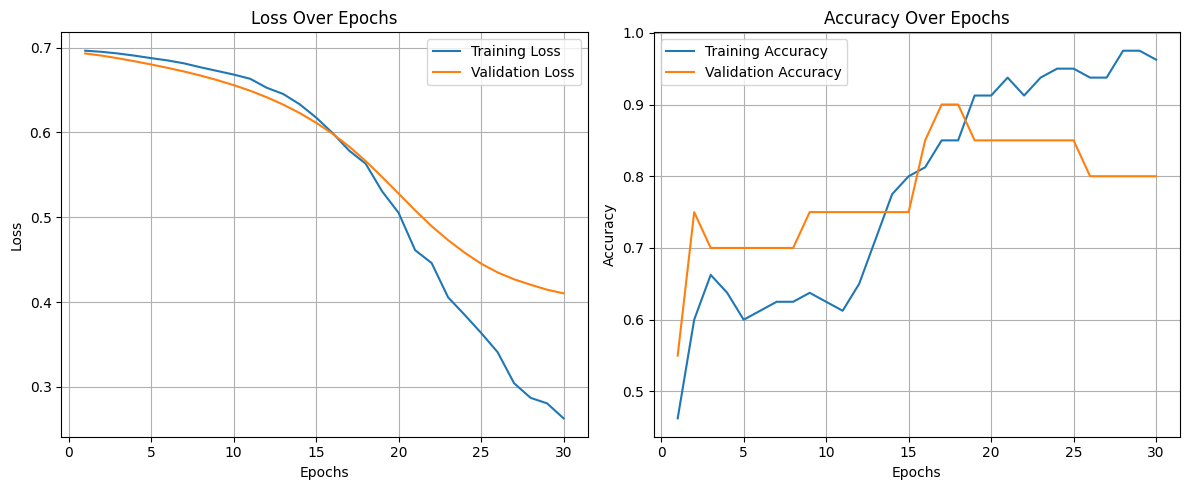

In [10]:
# 100 articles, LLM labeling



def fetch_pubmed_ids(query, max_results=60):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    search_url = f"{base_url}esearch.fcgi?db=pubmed&term={query}&retmax={max_results}&retmode=xml"
    response = requests.get(search_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch IDs: {response.status_code}")
    root = ET.fromstring(response.content)
    return [id_elem.text for id_elem in root.findall(".//Id")]

def fetch_pubmed_details(pmids):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    fetch_url = f"{base_url}efetch.fcgi?db=pubmed&id={','.join(pmids)}&retmode=xml"
    response = requests.get(fetch_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch details: {response.status_code}")
    fetch_root = ET.fromstring(response.content)
    articles = {}
    fetched_pmids = set()
    for article in fetch_root.findall(".//PubmedArticle"):
        pmid = article.findtext(".//PMID")
        title = article.findtext(".//ArticleTitle") or "No title"
        abstract = article.findtext(".//AbstractText") or ""
        articles[pmid] = {'title': title, 'abstract': abstract}
        fetched_pmids.add(pmid)
    missing = set(pmids) - fetched_pmids
    if missing:
        print(f"Warning: Missing PMIDs in fetch: {missing}")
    return articles

def get_ollama_embedding(text, model='nomic-embed-text'):
    response = ollama.embeddings(model=model, prompt=text)
    return np.array(response['embedding'])

def get_ollama_summary(text, model='llama3'):
    prompt = f"Summarize the following article in 2-3 sentences:\n\n{text}"
    response = ollama.generate(model=model, prompt=prompt)
    return response['response']


def normalize_embeddings(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    return (X - X_mean) / (X_std + 1e-8)  # Avoid division by zero


def create_article_data(query, max_results=60):
    all_pmids = fetch_pubmed_ids(query, max_results)
    train_pmids, test_pmids = train_test_split(all_pmids, test_size=0.2, random_state=42)
    train_articles = fetch_pubmed_details(train_pmids)
    test_articles = fetch_pubmed_details(test_pmids)
    
    X_train, y_train, df_train = process_articles(train_pmids, train_articles, cache_file="train_embeddings.pkl")
    X_test, y_test, df_test = process_articles(test_pmids, test_articles, cache_file="test_embeddings.pkl")
    
    X_train = normalize_embeddings(X_train)
    X_test = normalize_embeddings(X_test)
    
    assert not set(train_pmids) & set(test_pmids), "Overlap detected!"
    return X_train, y_train, X_test, y_test, df_train, df_test

def process_articles(pmids, articles_dict, cache_file="embeddings.pkl"):
    # Check for cached data
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached = pickle.load(f)
            cached_pmids = set(cached['pmids'])
            if set(pmids).issubset(cached_pmids):
                print("Using cached embeddings and labels.")
                X, y = [], []
                for pmid in pmids:
                    idx = cached['pmids'].index(pmid)
                    X.append(cached['X'][idx])
                    y.append(cached['y'][idx])
                return np.array(X), np.array(y), cached['df']  # Return cached DataFrame

    X, y, texts, summaries = [], [], [], []
    valid_pmids = []

    # Prompt with your bias
    prompt_template = """
You are an expert in machine learning and cancer research. Classify this summary as 'useful' (1) if it describes machine learning techniques (new or established) applied to cancer diagnosis or treatment with potential practical value (e.g., could improve outcomes or be implemented), or 'not useful' (0) if it’s purely theoretical, lacks ML, or is a review. Examples:
- Useful (1): "SVM model predicts breast cancer with 85% accuracy."
- Useful (1): "New CNN improves tumor detection in MRI scans."
- Not Useful (0): "Review of ML in oncology."
Return only the label (0 or 1).
Summary: {summary}
"""

    for pmid in pmids:
        if pmid not in articles_dict:
            print(f"Warning: PMID {pmid} not found, skipping.")
            continue
        article = articles_dict[pmid]
        full_text = f"{article['title']} {article['abstract']}"
        summary = get_ollama_summary(full_text)
        embedding = get_ollama_embedding(summary)
        X.append(embedding)
        prompt = prompt_template.format(summary=summary)
        response = ollama.generate(model='llama3', prompt=prompt)
        label = int(response['response'].strip())

        # Store data
        valid_pmids.append(pmid)
        texts.append(full_text)
        summaries.append(summary)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Create DataFrame
    df = pd.DataFrame({
        'pmid': valid_pmids,
        'full_text': texts,
        'summary': summaries,
        'label': y
    })

    # Print DataFrame instead of raw prints
    print("\nProcessed articles with LM labels:")
    print(df.to_string(index=False))  # Nicer formatting

    # Cache results, including DataFrame
    with open(cache_file, 'wb') as f:
        pickle.dump({'pmids': valid_pmids, 'X': X, 'y': y, 'df': df}, f)

    return X, y, df



DATA_FILE = "article_data.pkl"

def load_or_create_data(query, max_results):
    if os.path.exists(DATA_FILE):
        print(f"Loading saved data from {DATA_FILE}")
        with open(DATA_FILE, 'rb') as f:
            data = pickle.load(f)
            return data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['df_train'], data['df_test']
    else:
        print(f"Creating new data for query: {query}")
        X_train, y_train, X_test, y_test, df_train, df_test = create_article_data(query, max_results)
        data = {
            'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test,
            'df_train': df_train, 'df_test': df_test
        }
        with open(DATA_FILE, 'wb') as f:
            pickle.dump(data, f)
        print(f"Saved data to {DATA_FILE}")
        return X_train, y_train, X_test, y_test, df_train, df_test





if __name__ == "__main__":
    query = "machine learning cancer"
    max_results = 100

    # Load or create data
    X_train, y_train, X_test, y_test, df_train, df_test = load_or_create_data(query, max_results)

    # Print label balance
    print("Train label balance:", np.mean(y_train))
    print("Test label balance:", np.mean(y_test))

    # Build and train model
    model = funny_guy()
    model.add(Layer_Dense(768, 32, weight_regularizer_l2=1e-3))
    model.add(Activation_ReLU())
    model.add(Layer_Dropout(0.3))
    model.add(Activation_ReLU())
    model.add(Layer_Dense(32, 1, weight_regularizer_l2=1e-3))
    model.add(Activation_Sigmoid())
    model.set(
        loss=Loss_BinaryCrossEntropy(),
        optimizer=Optimizer_SGD(learning_rate=0.008, decay=1e-5, momentum=0.8),
        accuracy=Accuracy_Binary())
    model.finalize()
    history = model.train(X_train, y_train, epochs=30, batch_size=32, print_every=2, validation_data=(X_test, y_test))

    # Predictions and analysis
    predictions = model.predict(X_test)
    df_test['raw_prediction'] = predictions.flatten()
    df_test['binary_prediction'] = (predictions > 0.5).astype(int)
    print("\nTest DataFrame with Predictions:")
    print(df_test[['pmid', 'label', 'raw_prediction', 'binary_prediction']].to_string(index=False))
    print("Confusion Matrix:\n", pd.crosstab(df_test['label'], df_test['binary_prediction']))   
    
    # Plotting
    epochs_range = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Increasing the sample size to 100 helped tremendously, bringing accuracy way up and dropping loss across both training and validation. Will increasing the sample size further improve results? Below, the sample size is increased to 250. 

In [7]:
# SCRAP AND EMBED, store embeddings and data in a new file "big_article_data"


def process_articles(pmids, articles_dict, cache_file):
    # Check for cached data
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached = pickle.load(f)
            cached_pmids = set(cached['pmids'])
            if set(pmids).issubset(cached_pmids):
                print(f"Using cached embeddings from {cache_file}")
                X, y = [], []
                for pmid in pmids:
                    idx = cached['pmids'].index(pmid)
                    X.append(cached['X'][idx])
                    y.append(cached['y'][idx])
                return np.array(X), np.array(y), cached['df']

    X, y, texts, summaries = [], [], [], []
    valid_pmids = []

    prompt_template = """
You are an expert in machine learning and cancer research. Classify this summary as 'useful' (1) if it describes machine learning techniques (new or established) applied to cancer diagnosis or treatment with potential practical value (e.g., could improve outcomes or be implemented), or 'not useful' (0) if it’s purely theoretical, lacks ML, or is a review. Examples:
- Useful (1): "SVM model predicts breast cancer with 85% accuracy."
- Useful (1): "New CNN improves tumor detection in MRI scans."
- Not Useful (0): "Review of ML in oncology."
Return only the label (0 or 1).
Summary: {summary}
"""

    for pmid in pmids:
        if pmid not in articles_dict:
            print(f"Warning: PMID {pmid} not found, skipping.")
            continue
        article = articles_dict[pmid]
        full_text = f"{article['title']} {article['abstract']}"
        summary = get_ollama_summary(full_text)
        embedding = get_ollama_embedding(summary)
        X.append(embedding)
        prompt = prompt_template.format(summary=summary)
        response = ollama.generate(model='llama3', prompt=prompt)
        label = int(response['response'].strip())

        valid_pmids.append(pmid)
        texts.append(full_text)
        summaries.append(summary)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    df = pd.DataFrame({
        'pmid': valid_pmids,
        'full_text': texts,
        'summary': summaries,
        'label': y
    })

    print(f"\nProcessed articles with LM labels ({cache_file}):")
    print(df.to_string(index=False))

    with open(cache_file, 'wb') as f:
        pickle.dump({'pmids': valid_pmids, 'X': X, 'y': y, 'df': df}, f)

    return X, y, df

def create_article_data(query, max_results=60):
    all_pmids = fetch_pubmed_ids(query, max_results)
    train_pmids, test_pmids = train_test_split(all_pmids, test_size=0.2, random_state=42)
    train_articles = fetch_pubmed_details(train_pmids)
    test_articles = fetch_pubmed_details(test_pmids)
    
    X_train, y_train, df_train = process_articles(train_pmids, train_articles, cache_file=TRAIN_CACHE)
    X_test, y_test, df_test = process_articles(test_pmids, test_articles, cache_file=TEST_CACHE)
    
    X_train = normalize_embeddings(X_train)
    X_test = normalize_embeddings(X_test)
    
    assert not set(train_pmids) & set(test_pmids), "Overlap detected!"
    return X_train, y_train, X_test, y_test, df_train, df_test

def load_or_create_data(query, max_results):
    if os.path.exists(DATA_FILE):
        print(f"Loading saved data from {DATA_FILE}")
        with open(DATA_FILE, 'rb') as f:
            data = pickle.load(f)
            return data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['df_train'], data['df_test']
    else:
        print(f"Creating new data for query: {query}")
        X_train, y_train, X_test, y_test, df_train, df_test = create_article_data(query, max_results)
        data = {
            'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test,
            'df_train': df_train, 'df_test': df_test
        }
        with open(DATA_FILE, 'wb') as f:
            pickle.dump(data, f)
        print(f"Saved data to {DATA_FILE}")
        return X_train, y_train, X_test, y_test, df_train, df_test

# File paths for pickle files
DATA_FILE = "big_article_data.pkl"
TRAIN_CACHE = "big_train_embeddings.pkl"
TEST_CACHE = "big_test_embeddings.pkl"


# Main execution for scraping and embedding
if __name__ == "__main__":
    query = "machine learning cancer"
    max_results = 250
    X_train, y_train, X_test, y_test, df_train, df_test = load_or_create_data(query, max_results)
    print("Train label balance:", np.mean(y_train))
    print("Test label balance:", np.mean(y_test))






Loading saved data from big_article_data.pkl
Train label balance: 0.575
Test label balance: 0.56


In [ ]:
# TRAIN NEURAL NETWORK, DISPLAY RESULTS 


# Assuming X_train, y_train, X_test, y_test, df_test are available from previous cell
# Build and train model
model = funny_guy()
model.add(Layer_Dense(768, 32, weight_regularizer_l2=5e-4))
model.add(Activation_ReLU())
model.add(Layer_Dropout(0.25))
model.add(Layer_Dense(32, 1, weight_regularizer_l2=5e-4))
model.add(Activation_Sigmoid())
model.set(
    loss=Loss_BinaryCrossEntropy(),
    optimizer=Optimizer_SGD(learning_rate=0.008, decay=2e-5, momentum=0.82),
    accuracy=Accuracy_Binary()
)
model.finalize()

# Train model
history = model.train(X_train, y_train, epochs=28, batch_size=20, print_every=10, validation_data=(X_test, y_test))

# Predict and add to test DataFrame
predictions = model.predict(X_test)
df_test['raw_prediction'] = predictions.flatten()
df_test['binary_prediction'] = (predictions > 0.5).astype(int)

# Display test DataFrame
print("\nTest DataFrame with Predictions:")
print(df_test.to_string(index=False))
print("Confusion Matrix:\n", pd.crosstab(df_test['label'], df_test['binary_prediction']))


epoch: 1
step: 0, acc: 0.600, loss: 0.693, (data_loss: 0.6922480570398122, reg_loss: 0.001), lr: 0.008
step: 9, acc: 0.750, loss: 0.689, (data_loss: 0.687562530489725, reg_loss: 0.001), lr: 0.007998560259153352
training, acc: 0.625, loss: 0.692, (data_loss: 0.6908376089194573, reg_loss: 0.001), lr: 0.007998560259153352
validation, acc: 0.600, loss: 0.689
Val predictions: [1 1 1 1 1 1 1 1 1 1]
epoch: 2
step: 0, acc: 0.550, loss: 0.693, (data_loss: 0.6914899797695923, reg_loss: 0.001), lr: 0.007998400319936013
step: 9, acc: 0.700, loss: 0.679, (data_loss: 0.6777912369958529, reg_loss: 0.001), lr: 0.00799696115476119
training, acc: 0.660, loss: 0.684, (data_loss: 0.6831869778887727, reg_loss: 0.001), lr: 0.00799696115476119
validation, acc: 0.600, loss: 0.682
Val predictions: [1 1 1 1 1 1 1 1 1 1]
epoch: 3
step: 0, acc: 0.500, loss: 0.690, (data_loss: 0.6885532787832245, reg_loss: 0.001), lr: 0.007996801279488205
step: 9, acc: 0.650, loss: 0.665, (data_loss: 0.6633788645724927, reg_loss: 

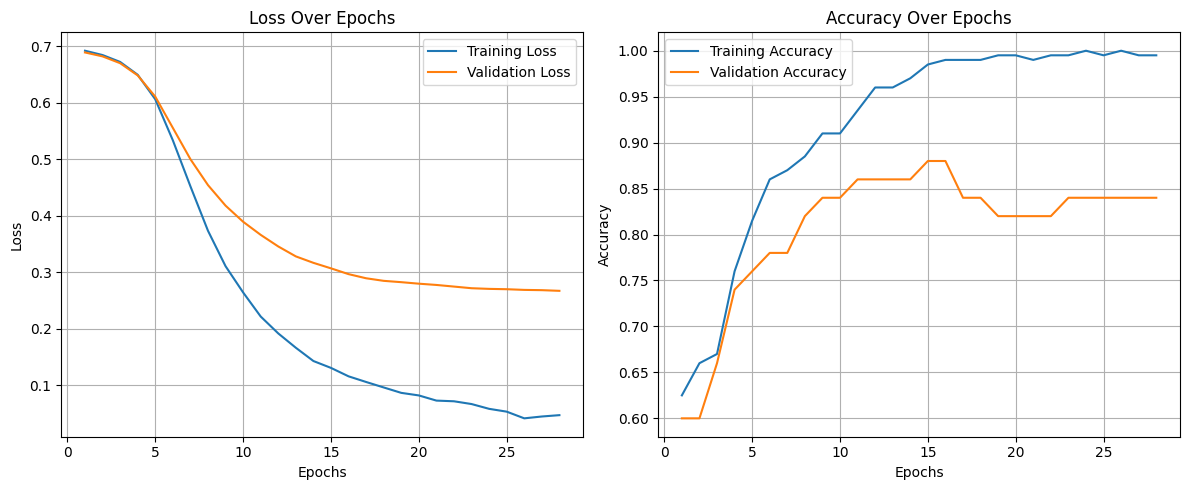

In [ ]:
# PLOT RESULTS 


epochs_range = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



At 250 samples, validation loss and training loss further decreased. However, training accuracy remained nearly the same.